## Used packages

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring, RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
)
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.parameters import Constant

## Feature importance

In [3]:
# Use get_model_for_problem_formulation function to get a workable version of the model for the EMA workbench
dike_model, planning_steps = get_model_for_problem_formulation(6)

                  0       1      2       3       4
project name                                      
A.1            0.19    0.17    NaN     NaN     NaN
A.2             NaN     NaN   0.05    0.02     NaN
A.3             NaN     NaN   0.11    0.04    0.01
A.4             NaN     NaN    NaN    0.06    0.05
A.5             NaN     NaN    NaN    0.12     NaN
costs_1e6     84.60  217.80  30.70  121.20  256.10


In [8]:

# Create a dictionary with all the policy lever values 0
zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})
pol0 = {}

# Create a policy class where all the policies are switched off (have value 0)
for key in dike_model.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})
policy0 = Policy("Policy 0", **pol0)

In [4]:
# Runs the experiments with the no policies and 50000 configurations of the scenarios using LHS sampling
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=50000,policies=policy0,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results

#Saves the results of the experiments
with open('./data/LHS_Scen_result.pkl', 'wb') as file:
    pickle.dump(results, file)

100%|██████████████████████████████████| 50000/50000 [1:43:39<00:00,  8.04it/s]


In [5]:
# Selects the columns that contain the uncertainties
experiments_unc =experiments.iloc[:,0:19]

# Change outcomes to df 
df = pd.DataFrame(outcomes) 

# Calculates and plots the feature scores
x = experiments_unc
y = df
fig, ax = plt.subplots(figsize=(20,20))
fs = feature_scoring.get_feature_scores_all(x, y,)
sns.heatmap(fs, cmap="viridis", annot=True,vmin=0.04)
plt.show()

In [9]:
# Selects the 20% percentage the worst outcomes for A5 specific outcomes 
y = ((df["A.5_Expected Number of Deaths"] > list(np.sort(df["A.5_Expected Number of Deaths"]))[np.int64(0.80* len(df["A.5_Expected Number of Deaths"]))])|(df['A.5_Expected Annual Damage'] > list(np.sort(df['A.5_Expected Annual Damage']))[np.int64(0.8* len(df['A.5_Expected Annual Damage']))]))

# Calculates and plots the feature scores for the worst outcomes for A5 specific outcomes 
fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

,1
0,
A.5_pfail,0.525045
A.3_pfail,0.119422
A.2_pfail,0.081836
A.1_pfail,0.078015
A.4_pfail,0.056990
A.1_Bmax,0.035610
A.2_Bmax,0.011984
A.3_Bmax,0.011402
A.5_Brate,0.007859


In [10]:
# Selects the 20% percentage the worst outcomes for the general situation
y = ((df['Expected Number of Deaths'] > list(np.sort(df["Expected Number of Deaths"]))[int(0.8* len(df['Expected Number of Deaths']))])|(df['Expected Annual Damage'] > list(np.sort(df["Expected Annual Damage"]))[int(0.8* len(df['Expected Annual Damage']))]))

# Calculates and plots the feature scores for the worst outcomes for the general situation
fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

,1
0,
A.3_pfail,0.501724
A.1_pfail,0.215233
discount rate 2,0.058708
discount rate 0,0.058580
discount rate 1,0.057421
A.1_Bmax,0.019187
A.2_pfail,0.011578
A.5_pfail,0.007728
A.3_Brate,0.007089


## Filter important uncertainties and create samples SOBOL 

In [6]:
# Use get_model_for_problem_formulation function to get a workable version of the model for the EMA workbench
dike_model_1, planning_steps = get_model_for_problem_formulation(6)

# Will contain uncertainties that need to be made constant
dele = []
# Cycle over levers and add levers to dele if they need to be constant
for x in dike_model_1.uncertainties:
    if x.name not in ["A.1_pfail","A.2_pfail","A.3_pfail","A.4_pfail","A.5_pfail", "discount rate 0","discount rate 1","discount rate 2"]:
        dele.append(x.name)
        
# Remove uncertainties that are in dele
for i in dele:
    dike_model_1.uncertainties.__delitem__(i)

# Create Constants of the policies
constant_entries = [
    Constant('A.0_ID flood wave shape', 17),
    Constant('A.1_Bmax', 190), Constant('A.1_Brate', 1.5),
    Constant('A.2_Bmax', 190), Constant('A.2_Brate', 1.5),
    Constant('A.3_Bmax', 190), Constant('A.3_Brate', 1.5),
    Constant('A.4_Bmax', 190), Constant('A.4_Brate', 1.5),
    Constant('A.5_Bmax', 190), Constant('A.5_Brate', 1.5)
]
# Add the policies as constants
for var in constant_entries:
    dike_model_1.constants.extend(var)



                  0       1      2       3       4
project name                                      
A.1            0.19    0.17    NaN     NaN     NaN
A.2             NaN     NaN   0.05    0.02     NaN
A.3             NaN     NaN   0.11    0.04    0.01
A.4             NaN     NaN    NaN    0.06    0.05
A.5             NaN     NaN    NaN    0.12     NaN
costs_1e6     84.60  217.80  30.70  121.20  256.10


In [ ]:
# Runs the experiments with fewer uncertainties and SOBOL sampling, which results in 151200 experiments, because there are 8 uncertainties
with MultiprocessingEvaluator(dike_model_1) as evaluator:
    results3 = evaluator.perform_experiments(scenarios=8400,policies=policy0,uncertainty_sampling=Samplers.SOBOL)

experiments3, outcomes3 = results3

C:\Users\roelo\anaconda3\envs\MD\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
  0%|                                   | 217/151200 [00:30<4:09:58, 10.07it/s]

In [31]:
# Loads the reference scenarios used in the experiments
with open('./data/SOBOL_Scen_result.pkl', 'wb') as file:
    pickle.dump(results3, file)

# Selects the columns that contain the levers
experiments_unc = experiments3.iloc[:, 0:5]

# Change outcomes to df 
df = pd.DataFrame(outcomes3)

In [20]:
df_feature_importance_out.to_csv('data\OpenScenRes.csv')

NameError: name 'df_feature_importance_out' is not defined

## SOBOL analysis 

In [32]:
# Gets a problem formulations which is usable for the Salib module
problem = get_SALib_problem(dike_model_1.uncertainties)

In [ ]:
# Remove columns which are not usefull for the scenario sensitivity
df.drop(columns=["Expected Evacuation Costs","Total Investments Cost"],inplace=True)

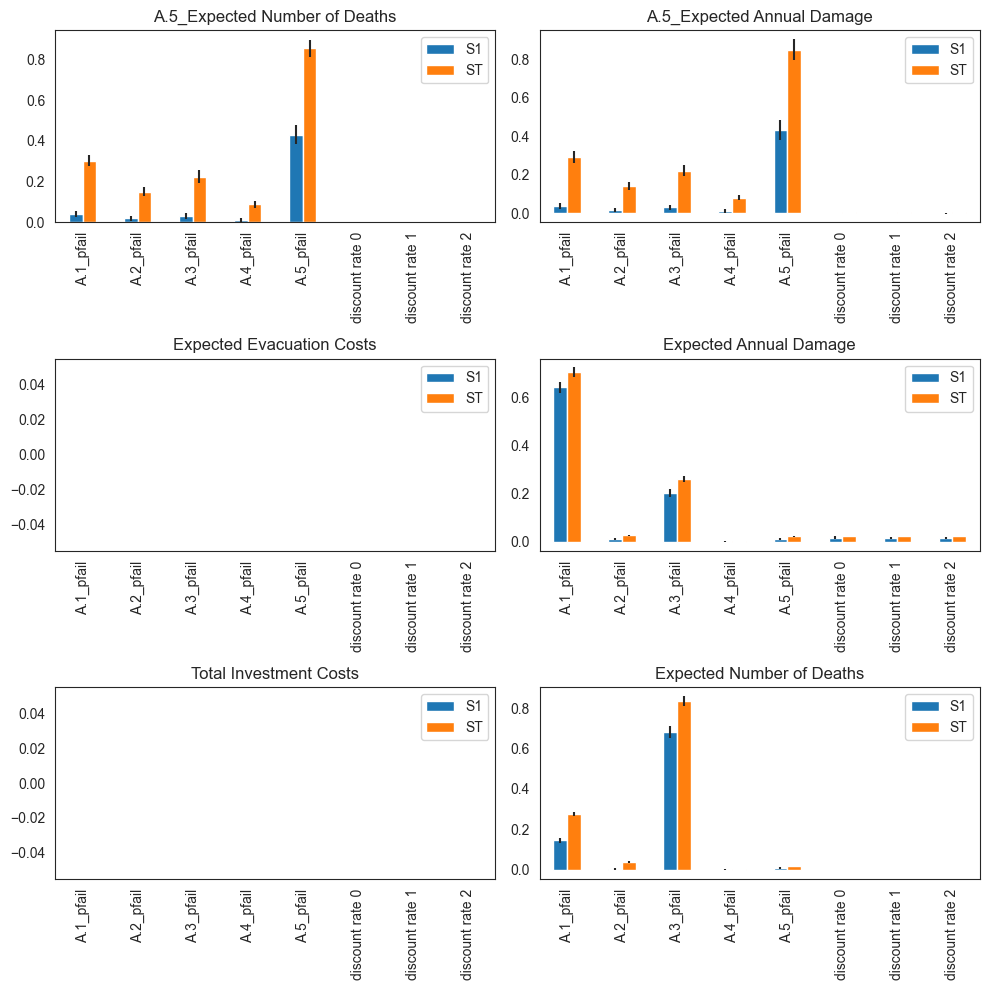

In [33]:
sns.set_style('white')
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.flatten()
# loops over outcomes
for index,kpi in enumerate(df.columns):
    #Calculates sobol scores
    Si = sobol.analyze(problem,np.array(outcomes3[kpi]), calc_second_order=True, print_to_console=False)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    
    
    
    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]
    ax[index].title.set_text(kpi) 
    indices.plot.bar(yerr=err.values.T,ax=ax[index])
    # fig.set_size_inches(8,6)
    # fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()